In [184]:
import sktime
import pandas as pd
import numpy as np
import sklearn
plt.style.use('ggplot')

# Продолжаем говорить про работу с временными рядами

In [186]:
from sktime.datasets import load_airline
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.forecasting.base import ForecastingHorizon
from sktime.utils.plotting import plot_series
from sktime.performance_metrics.forecasting import mean_absolute_percentage_error

y = load_airline()
y_train, y_test = temporal_train_test_split(y, test_size=36)
fh = ForecastingHorizon(y_test.index, is_relative=False)

# Преобразование Бокса-Кокса

In [192]:
from sktime.transformations.series.boxcox import BoxCoxTransformer

Optimal lambda is 0.14802265137037945


(<Figure size 1152x288 with 1 Axes>, <AxesSubplot:>)

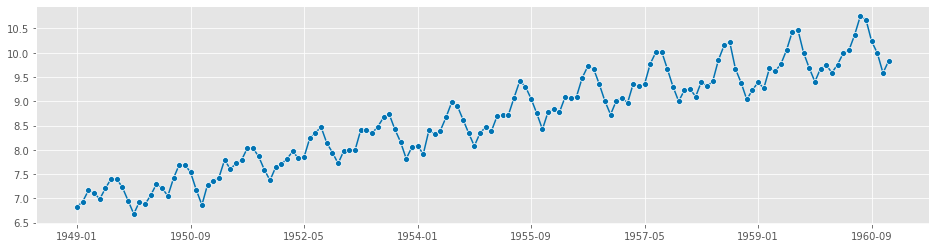

In [193]:
box = BoxCoxTransformer()
y_box = box.fit_transform(y)
print(f'Optimal lambda is {box.lambda_}')
plot_series(y_box)

(<Figure size 1152x288 with 1 Axes>, <AxesSubplot:>)

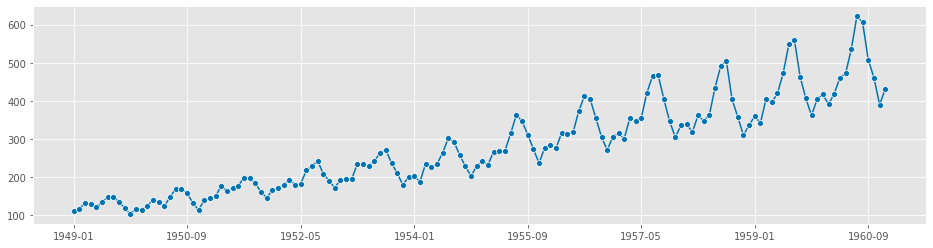

In [194]:
plot_series(box.inverse_transform(y_box))

In [195]:
import random
import matplotlib.pyplot as plt
x = np.arange(1,100)
y_trend = x**3 + np.random.normal(loc = 0, scale = x**2.3)
y_trend = pd.DataFrame(y_trend)
y_trend.index = pd.date_range('2014-01-01',periods=99,freq='M')

(<Figure size 1152x288 with 1 Axes>, <AxesSubplot:>)

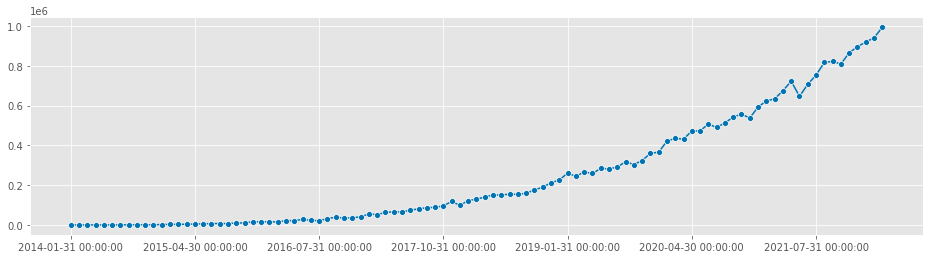

In [196]:
plot_series(y_trend)

Optimal lambda is 0.2378318378151317


(<Figure size 1152x288 with 1 Axes>, <AxesSubplot:>)

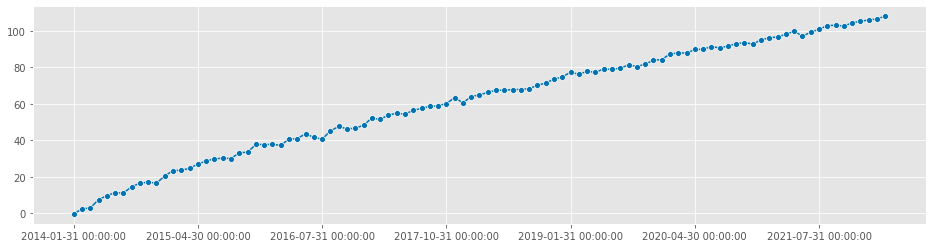

In [197]:
box = BoxCoxTransformer()
y_box = box.fit_transform(y_trend)
print(f'Optimal lambda is {box.lambda_}')
plot_series(y_box)

# STL

In [198]:
def compose(y,transformer):
    yt = transformer.fit_transform(y)
    fig = plt.figure(figsize = (16,9))
    ax1 = fig.add_subplot(3, 1, 1)
    plot_series(yt['trend'],ax=ax1)

    ax2 = fig.add_subplot(3, 1, 2)
    plot_series(yt['seasonal'],ax=ax2)

    ax3 = fig.add_subplot(3, 1, 3)
    plot_series(yt['resid'],ax=ax3)

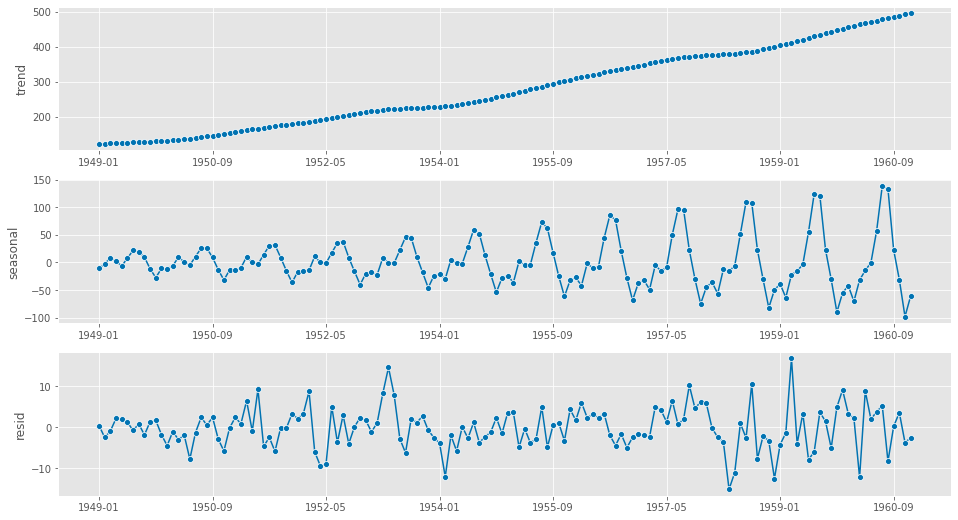

In [199]:
from sktime.transformations.series.detrend import STLTransformer
transformer = STLTransformer(sp=12, seasonal=7, return_components=True)  
compose(y,transformer)

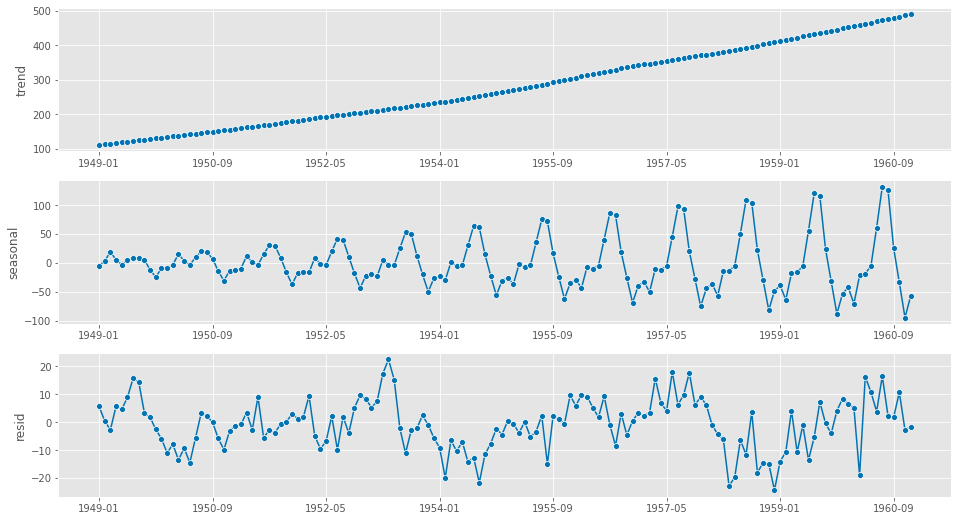

In [200]:
from sktime.transformations.series.detrend import STLTransformer
transformer = STLTransformer(sp=12, seasonal=39,trend=59, return_components=True)  
compose(y,transformer)

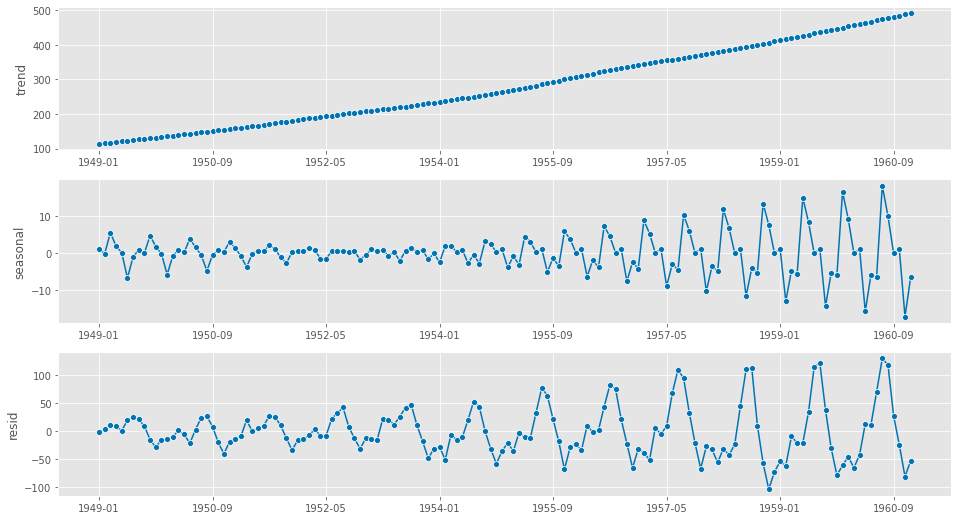

In [201]:
from sktime.transformations.series.detrend import STLTransformer
transformer = STLTransformer(sp=7, seasonal=59,trend=59, return_components=True)  
compose(y,transformer)

In [202]:
df = pd.read_csv('../data/traffic.csv', parse_dates=['report_dt'])
y_traffic = df[df.cross==1].resample('D', on='report_dt').sum()['traffic']
y_traffic_train, y_traffic_test = temporal_train_test_split(y_traffic, test_size=60)

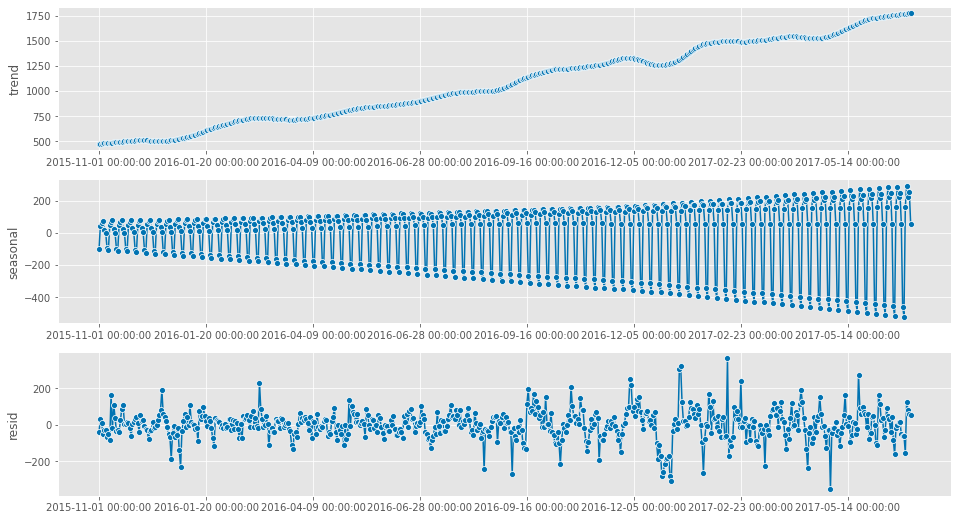

In [203]:
from sktime.transformations.series.detrend import STLTransformer
transformer = STLTransformer(sp=7, seasonal=61,trend=61, return_components=True)  
compose(y_traffic,transformer)

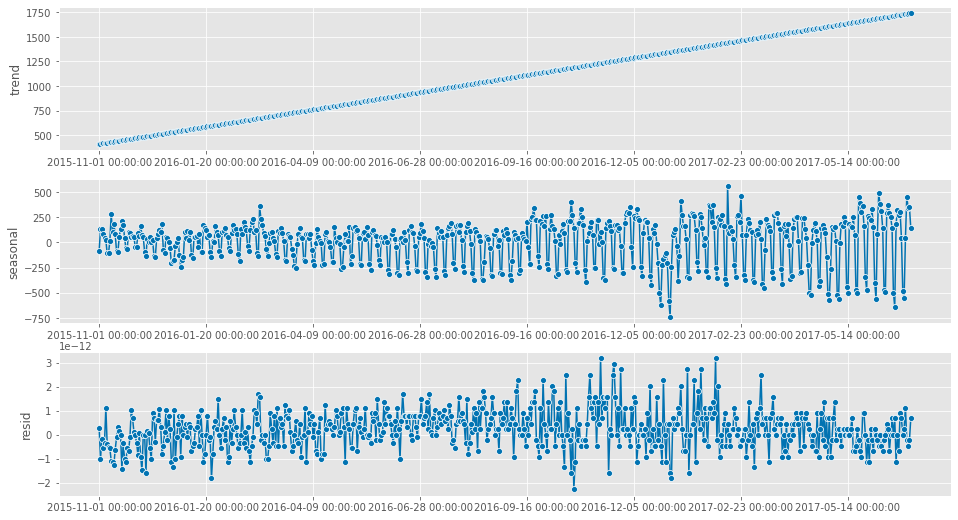

In [204]:
from sktime.transformations.series.detrend import STLTransformer
transformer = STLTransformer(sp=365, seasonal=367,trend=367, return_components=True)  
compose(y_traffic,transformer)

## Прогнозирование с помощью STL

(<Figure size 1152x288 with 1 Axes>,
 <AxesSubplot:ylabel='Number of airline passengers'>)

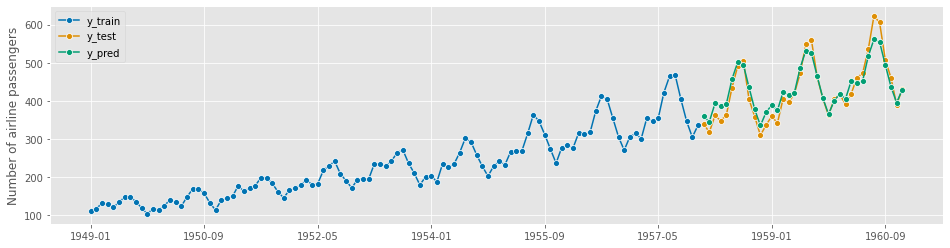

In [205]:
from sktime.forecasting.trend import STLForecaster
forecaster = STLForecaster(sp=12)  
forecaster.fit(y_train)
y_pred = forecaster.predict(fh)
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])

In [206]:
df = pd.read_csv('../data/traffic.csv', parse_dates=['report_dt'])
y_traffic = df[df.cross==1].resample('D', on='report_dt').sum()['traffic']
y_traffic_train, y_traffic_test = temporal_train_test_split(y_traffic, test_size=60)

MAPE: 0.09337033476671532
MAE: 172.81771468507625


(<Figure size 1152x288 with 1 Axes>, <AxesSubplot:ylabel='traffic'>)

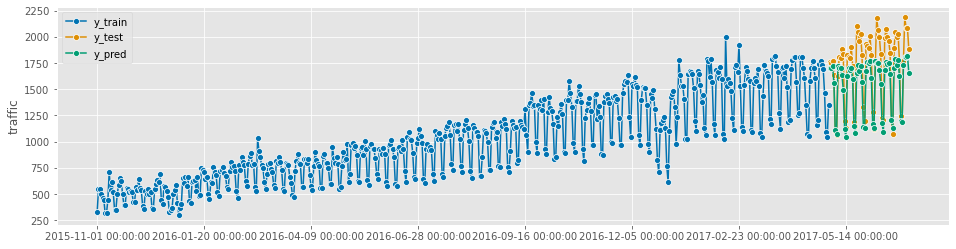

In [207]:
from sktime.performance_metrics.forecasting import mean_absolute_error
forecaster = STLForecaster(sp=28,seasonal = 31,trend=61)
forecaster.fit(y_traffic_train)
y_pred = forecaster.predict(y_traffic_test.index)
print('MAPE:',mean_absolute_percentage_error(y_traffic_test, y_pred))
print('MAE:',mean_absolute_error(y_traffic_test, y_pred))
plot_series(y_traffic_train, y_traffic_test, y_pred, labels=["y_train", "y_test", "y_pred"])

# STL + BoxCox

<AxesSubplot:ylabel='resid'>

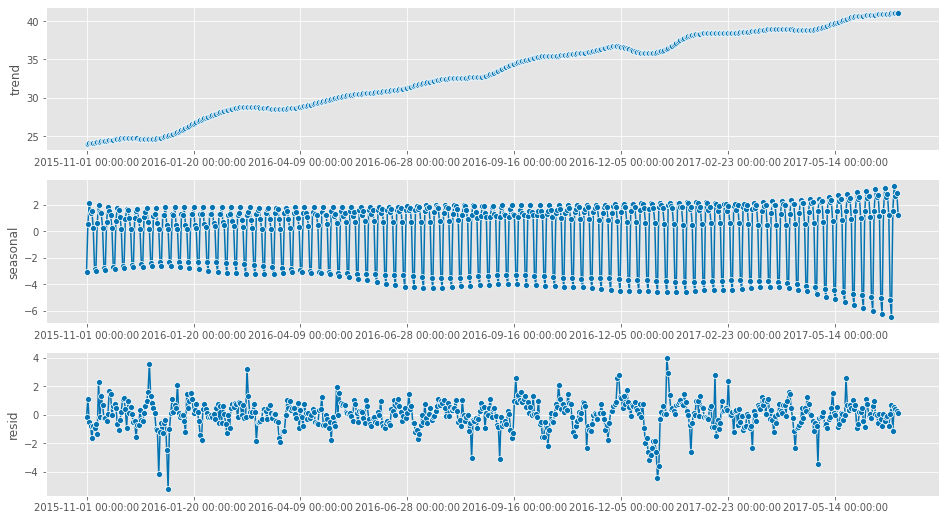

In [208]:
box = BoxCoxTransformer()
y_traffic_box = box.fit_transform(y_traffic)
transformer = STLTransformer(sp=7, seasonal=17,trend=61, return_components=True)
y_traffic_box_t = transformer.fit_transform(y_traffic_box)

fig = plt.figure(figsize = (16,9))
ax1 = fig.add_subplot(3, 1, 1)
plot_series(y_traffic_box_t['trend'],ax=ax1)

ax2 = fig.add_subplot(3, 1, 2)
plot_series(y_traffic_box_t['seasonal'],ax=ax2)

ax3 = fig.add_subplot(3, 1, 3)
plot_series(y_traffic_box_t['resid'],ax=ax3)

In [209]:
#pipeline: Box-Cox + STL
y = load_airline()
y_train, y_test = temporal_train_test_split(y, test_size=36)
fh = ForecastingHorizon(y_test.index, is_relative=False)

from sktime.pipeline import make_pipeline
pipe = make_pipeline(BoxCoxTransformer(), STLForecaster(sp=28, seasonal=31, trend=61))

MAPE: 0.08513667536659436
MAE: 157.20441493053593


(<Figure size 1152x288 with 1 Axes>, <AxesSubplot:ylabel='traffic'>)

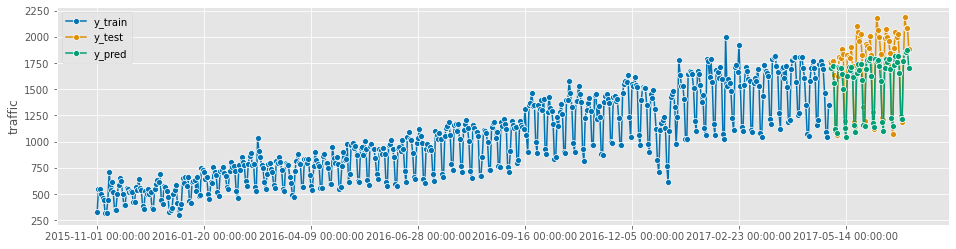

In [210]:
pipe.fit(y_traffic_train)
y_pred = pipe.predict(y_traffic_test.index)
print('MAPE:',mean_absolute_percentage_error(y_traffic_test, y_pred))
print('MAE:',mean_absolute_error(y_traffic_test, y_pred))
plot_series(y_traffic_train, y_traffic_test, y_pred, labels=["y_train", "y_test", "y_pred"])

# ETS

In [1]:
from sktime.datasets import load_uschange
from sktime.utils.plotting import plot_series
from sktime.forecasting.model_selection import temporal_train_test_split
import matplotlib.pyplot as plt
import pandas as pd 
import numpy as np

In [2]:
from sktime.forecasting.exp_smoothing import ExponentialSmoothing
from sktime.forecasting.ets import AutoETS
from sktime.performance_metrics.forecasting import mean_absolute_percentage_error

In [12]:
from sktime.datasets import load_macroeconomic, load_airline

from sktime.forecasting.model_selection import ExpandingWindowSplitter, ForecastingGridSearchCV

from sktime.utils.plotting import plot_correlations
from sktime.performance_metrics.forecasting import mean_absolute_percentage_error
from sktime.performance_metrics.forecasting import mean_absolute_error
plt.style.use('ggplot')
plt.rcParams["figure.figsize"] = (20,5)

In [4]:
df = pd.read_csv('../data/traffic.csv', parse_dates=['report_dt'])
y_traffic = df[df.cross==1].resample('D', on='report_dt').sum()['traffic']
y_traffic_train, y_traffic_test = temporal_train_test_split(y_traffic, test_size=60)

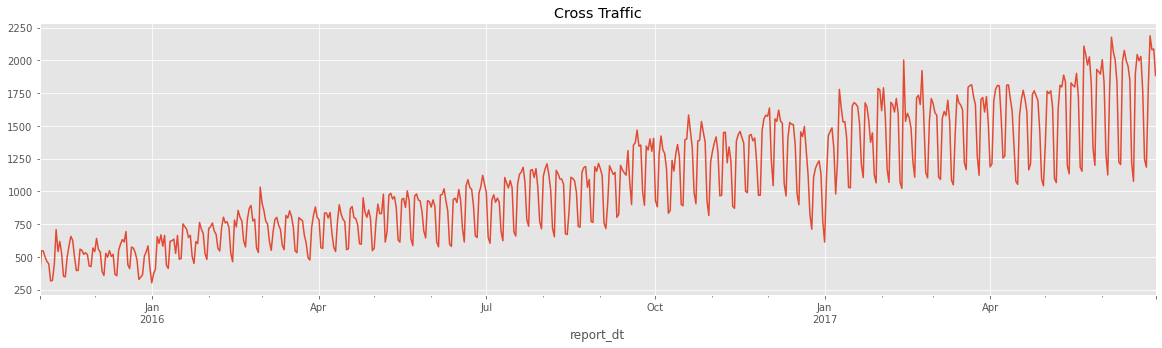

In [5]:
y_traffic.plot()
plt.title("Cross Traffic");

In [14]:
def show_predict(forecaster, y, test_size = 60):
    y_train, y_test = temporal_train_test_split(y, test_size=test_size)
    forecaster.fit(y_train)
    y_pred = forecaster.predict(y_test.index)
    print('MAPE:',mean_absolute_percentage_error(y_test, y_pred))
    print('MAE:',mean_absolute_error(y_test, y_pred))
    plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])

MAPE: 0.23193284975250117
MAE: 398.8071017085304


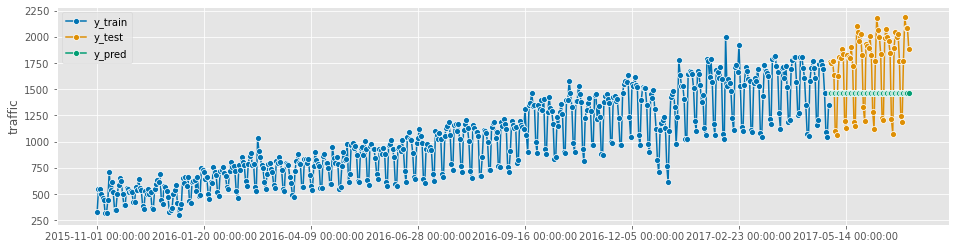

In [15]:
#ETS(A,N,N)
forecaster = ExponentialSmoothing()
show_predict(forecaster, y_traffic)

MAPE: 0.22569737291523306
MAE: 380.4533997900573


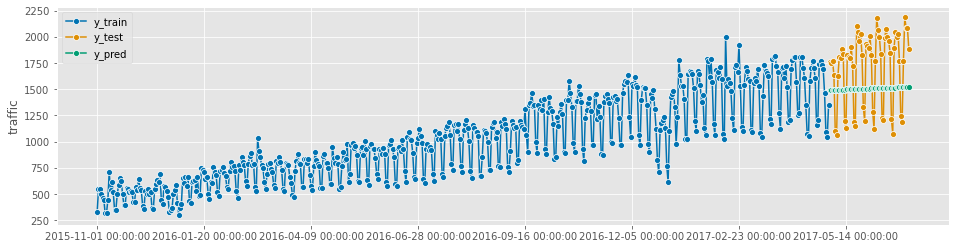

In [18]:
#ETS(A,A,N)
forecaster = ExponentialSmoothing(trend='add')
show_predict(forecaster, y_traffic)

MAPE: 0.304164914790583
MAE: 527.345431528766


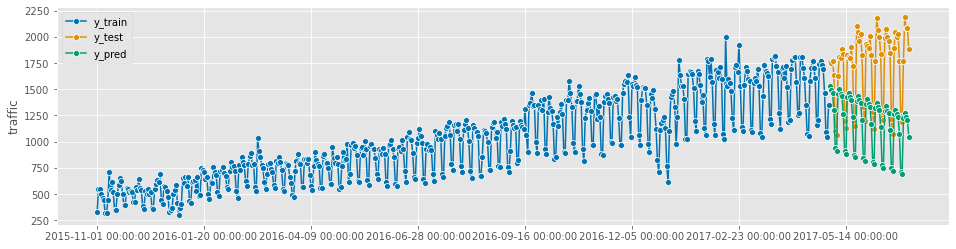

In [23]:
#ETS(A,A,A)
forecaster = ExponentialSmoothing(trend='additive', seasonal='add',sp=7)
show_predict(forecaster, y_traffic)

MAPE: 0.10950887448839043
MAE: 195.6036335013453


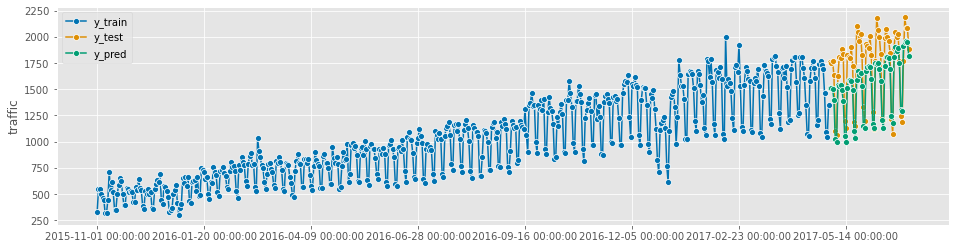

In [28]:
#ETS(A,M,M)
forecaster = ExponentialSmoothing(trend='mul', seasonal='mul',sp=28)
show_predict(forecaster, y_traffic)

MAPE: 0.18801193888163956
MAE: 336.59970696036527


/Users/belyakov/miniforge3/envs/env_tf/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err


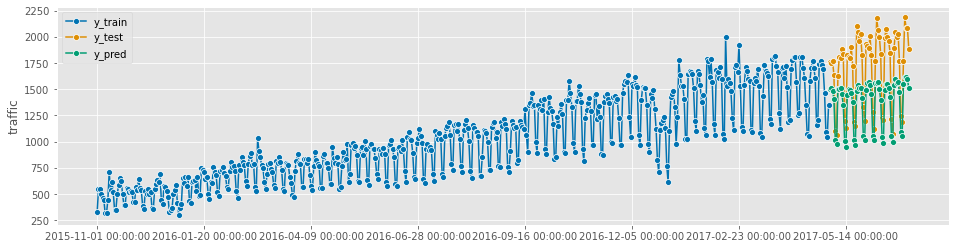

In [45]:
#ETS(A,A_d,M)
forecaster = ExponentialSmoothing(trend='mul',damped_trend=False,seasonal='mul',sp=28, use_boxcox=True)
show_predict(forecaster, y_traffic)

MAPE: 0.1414656763091465
MAE: 256.7330632881121


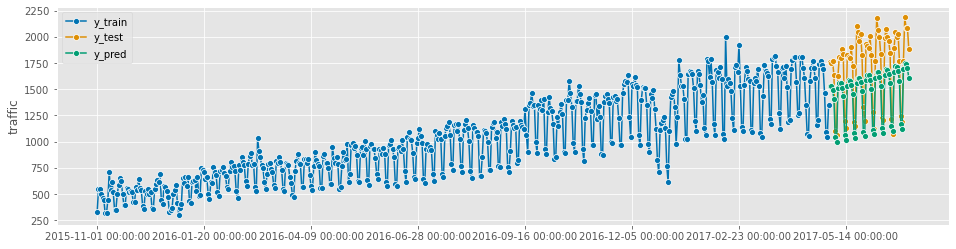

In [56]:
forecaster = AutoETS(error='mul',trend='mul', seasonal='mul', sp=7)
show_predict(forecaster, y_traffic)

MAPE: 0.14419011117113853
MAE: 261.5955307164712


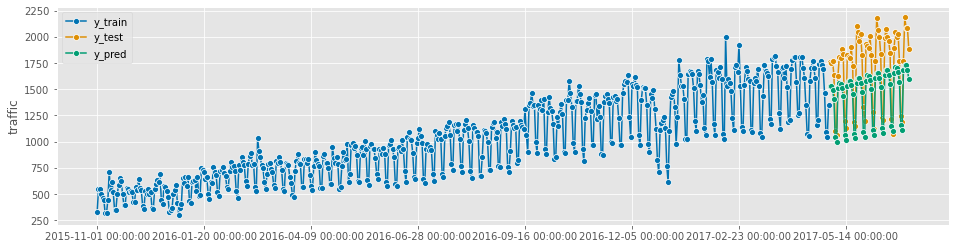

In [58]:
forecaster = AutoETS(auto=True,sp=7)
show_predict(forecaster, y_traffic)

In [61]:
print(forecaster.summary())

                                 ETS Results                                  
Dep. Variable:                traffic   No. Observations:                  548
Model:                       ETS(MAM)   Log Likelihood               -3148.955
Date:                Tue, 21 Feb 2023   AIC                           6323.911
Time:                        15:19:37   BIC                           6379.892
Sample:                    11-01-2015   HQIC                          6345.791
                         - 05-01-2017   Scale                            0.007
Covariance Type:               approx                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
smoothing_level        0.4562      0.053      8.676      0.000       0.353       0.559
smoothing_trend     4.562e-05      0.004      0.011      0.991      -0.008       0.008
smoothing_seasonal  

# Online users

In [100]:
y = pd.read_csv('hour_online.csv', index_col=['Time'], parse_dates=['Time']).Users
y.index = pd.PeriodIndex(y.index, freq="H")
y = y.astype(float)

(<Figure size 1152x288 with 1 Axes>, <AxesSubplot:ylabel='Users'>)

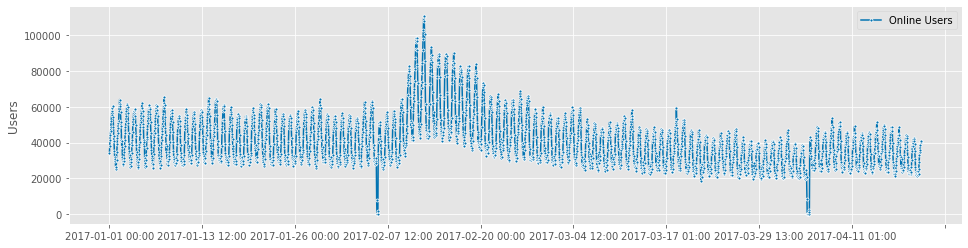

In [101]:
plot_series(y, labels=['Online Users'],markers='.')

In [102]:
y[y<10000] = np.nan
y = y.interpolate()

(<Figure size 1152x288 with 1 Axes>, <AxesSubplot:ylabel='Users'>)

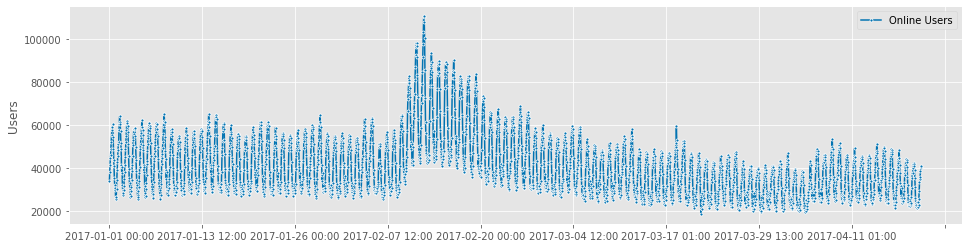

In [103]:
plot_series(y, labels=['Online Users'],markers='.')

In [104]:
y_train, y_test = temporal_train_test_split(y, test_size=48)

In [105]:
from sktime.forecasting.base import ForecastingHorizon

fh = ForecastingHorizon(list(range(1, len(y_test)+1)))

forecaster = AutoETS(sp=24)
param_grid = {
    'error': ['add', 'mul'],
    'trend': [None, 'add'],
    'seasonal': ['mul','add'],
}

cv = ExpandingWindowSplitter(
    initial_window=700,
    step_length=100,
    # start_with_window=True,
    fh=fh)

In [106]:
from cv_plot import plot_windows

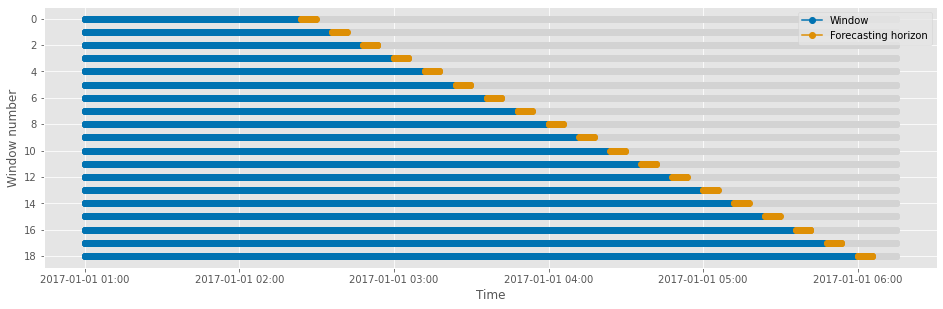

In [107]:
plot_windows(cv,y)

In [108]:
gscv = ForecastingGridSearchCV(
    forecaster=forecaster,
    param_grid=param_grid,
    cv=cv,
    verbose=1,
    n_jobs=-1,error_score='raise'
    )
gscv.fit(y_train);

Fitting 19 folds for each of 8 candidates, totalling 152 fits


In [109]:
gscv.best_params_

{'error': 'mul', 'seasonal': 'mul', 'trend': None}

(<Figure size 1152x288 with 1 Axes>, <AxesSubplot:>)

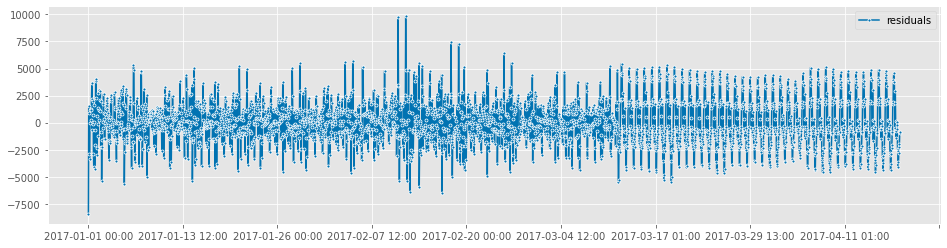

In [113]:
resid = gscv.predict_residuals()

plot_series(resid, labels=['residuals'], markers='.')

Forecast error: 0.06893744911596587


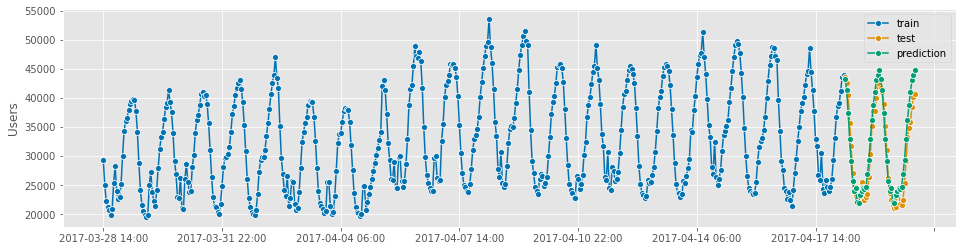

In [116]:
y_pred = gscv.predict(fh)
plot_series(y_train.tail(500), y_test, y_pred,  labels=['train', 'test', 'prediction']);

print(f'Forecast error: {mean_absolute_percentage_error(y_test, y_pred)}')